In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tslearn.clustering import TimeSeriesKMeans
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import warnings 
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from pmdarima.arima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

warnings.filterwarnings('ignore')

C:\Users\Oran Nahum\AppData\Local\Temp\ipykernel_23828\2500685615.py:16: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
original_df = pd.read_csv('sales_per_store_per_sku_ord_2.csv')
original_df

,store,sku,date,sales
0,1186,601516,2016-02-04,20.0
1,1186,601516,2016-02-05,11.0
2,1186,601516,2016-02-06,10.0
3,1186,601516,2016-02-08,10.0
4,1186,601516,2016-02-09,10.0
...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0
161525,194,100085056000002,2021-05-30,3.0
161526,194,100085056000002,2021-05-31,1.0
161527,194,100085056000002,2021-06-12,2.0


In [3]:
original_df['date'] = pd.to_datetime(original_df['date'])

In [4]:
original_df['day_count'] = (original_df['date'] - original_df['date'].min()).dt.days
original_df['month_count'] = (original_df['date'].dt.year - original_df['date'].min().year) * 12 + original_df['date'].dt.month - original_df['date'].min().month
original_df['week_number'] = original_df['date'].dt.isocalendar().week
original_df['year_count'] = original_df['date'].dt.year - original_df['date'].min().year
original_df['day_of_week'] = original_df['date'].dt.dayofweek
original_df['day_of_month'] = original_df['date'].dt.day
original_df['day_of_week_name'] = original_df['date'].dt.day_name()
original_df['month_of_year'] = original_df['date'].dt.month
original_df['year'] = original_df['date'].dt.year
original_df

,store,sku,date,sales,day_count,month_count,week_number,year_count,day_of_week,day_of_month,day_of_week_name,month_of_year,year
0,1186,601516,2016-02-04,20.0,1098,36,5,3,3,4,Thursday,2,2016
1,1186,601516,2016-02-05,11.0,1099,36,5,3,4,5,Friday,2,2016
2,1186,601516,2016-02-06,10.0,1100,36,5,3,5,6,Saturday,2,2016
3,1186,601516,2016-02-08,10.0,1102,36,6,3,0,8,Monday,2,2016
4,1186,601516,2016-02-09,10.0,1103,36,6,3,1,9,Tuesday,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0,3037,99,21,8,3,27,Thursday,5,2021
161525,194,100085056000002,2021-05-30,3.0,3040,99,21,8,6,30,Sunday,5,2021
161526,194,100085056000002,2021-05-31,1.0,3041,99,22,8,0,31,Monday,5,2021
161527,194,100085056000002,2021-06-12,2.0,3053,100,23,8,5,12,Saturday,6,2021


In [5]:
original_df

,store,sku,date,sales,day_count,month_count,week_number,year_count,day_of_week,day_of_month,day_of_week_name,month_of_year,year
0,1186,601516,2016-02-04,20.0,1098,36,5,3,3,4,Thursday,2,2016
1,1186,601516,2016-02-05,11.0,1099,36,5,3,4,5,Friday,2,2016
2,1186,601516,2016-02-06,10.0,1100,36,5,3,5,6,Saturday,2,2016
3,1186,601516,2016-02-08,10.0,1102,36,6,3,0,8,Monday,2,2016
4,1186,601516,2016-02-09,10.0,1103,36,6,3,1,9,Tuesday,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0,3037,99,21,8,3,27,Thursday,5,2021
161525,194,100085056000002,2021-05-30,3.0,3040,99,21,8,6,30,Sunday,5,2021
161526,194,100085056000002,2021-05-31,1.0,3041,99,22,8,0,31,Monday,5,2021
161527,194,100085056000002,2021-06-12,2.0,3053,100,23,8,5,12,Saturday,6,2021


In [95]:
print(original_df.loc[original_df['date'].dt.year == 2013]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2014]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2015]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2016]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2017]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2018]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2019]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2020]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2021]['week_number'].max())
print(original_df.loc[original_df['date'].dt.year == 2022]['week_number'].max())

52
52
53
53
52
52
52
53
53
52


In [6]:
agg_month_item_df = original_df.pivot_table(index='month_count', columns='sku', values='sales', fill_value=0, aggfunc=np.sum) 
agg_month_item_df = agg_month_item_df.reindex(list(range(agg_month_item_df.index.min(), agg_month_item_df.index.max()+1)),fill_value=0) / agg_month_item_df.mean()
agg_month_store_df = original_df.pivot_table(index='month_count', columns='store', values='sales', fill_value=0, aggfunc=np.sum) 
agg_month_store_df = agg_month_store_df.reindex(list(range(agg_month_store_df.index.min(), agg_month_store_df.index.max()+1)),fill_value=0) / agg_month_store_df.mean()

In [96]:
"""
original_df['week_count'] = [0] * len(original_df)
week_count = []
for index in range(len(original_df)):
    if original_df.iloc[index]['year'] == 2013 : 
        week_count.append(original_df.iloc[index]['week_number'] )
    elif original_df.iloc[index]['year'] == 2014 : 
        week_count.append(original_df.iloc[index]['week_number'] + 52)
    elif (original_df.iloc[index]['year'] == 2015) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*2)
    elif (original_df.iloc[index]['year'] == 2016) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*2 + 53)
    elif (original_df.iloc[index]['year'] == 2017) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*2 + 53*2)
    elif (original_df.iloc[index]['year'] == 2018) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*3 + 53*2 )   
    elif (original_df.iloc[index]['year'] == 2019) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*4 + 53*2  )  
    elif (original_df.iloc[index]['year'] == 2020) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*5 + 53*2  )      
    elif (original_df.iloc[index]['year'] == 2021) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*5 + 53*3 )       
    elif (original_df.iloc[index]['year'] == 2022) :
        week_count.append(original_df.iloc[index]['week_number'] + 52*5 + 53*4)     
    print(index)   
"""

"\noriginal_df['week_count'] = [0] * len(original_df)\nweek_count = []\nfor index in range(len(original_df)):\n    if original_df.iloc[index]['year'] == 2013 : \n        week_count.append(original_df.iloc[index]['week_number'] )\n    elif original_df.iloc[index]['year'] == 2014 : \n        week_count.append(original_df.iloc[index]['week_number'] + 52)\n    elif (original_df.iloc[index]['year'] == 2015) :\n        week_count.append(original_df.iloc[index]['week_number'] + 52*2)\n    elif (original_df.iloc[index]['year'] == 2016) :\n        week_count.append(original_df.iloc[index]['week_number'] + 52*2 + 53)\n    elif (original_df.iloc[index]['year'] == 2017) :\n        week_count.append(original_df.iloc[index]['week_number'] + 52*2 + 53*2)\n    elif (original_df.iloc[index]['year'] == 2018) :\n        week_count.append(original_df.iloc[index]['week_number'] + 52*3 + 53*2 )   \n    elif (original_df.iloc[index]['year'] == 2019) :\n        week_count.append(original_df.iloc[index]['week_

In [7]:
agg_month_store_df

store,2,3,5,6,7,8,10,11,15,18,...,2610,2671,2672,2690,2940,2970,3335,4123,5008,6301
month_count,,,,,,,,,,,,,,,,,,,,,
0,2.178106,0.0,0.000000,2.211211,0.000000,1.099538,0.0,0.000000,2.905491,0.458095,...,0.935730,0.374607,0.000000,1.145046,0.0,1.050000,0.000000,0.0,0.0,0.0
1,1.843013,0.0,0.000000,3.906473,0.000000,2.361508,0.0,0.000000,2.418925,1.256489,...,2.511193,1.034627,0.000000,2.205274,0.0,1.254717,0.000000,0.0,0.0,0.0
2,2.429426,0.0,0.000000,1.474141,0.000000,1.012075,0.0,0.000000,2.599650,0.706775,...,0.381931,1.177335,0.000000,0.593728,0.0,1.129245,0.000000,0.0,0.0,0.0
3,1.591693,0.0,0.000000,5.085785,0.000000,1.668049,0.0,0.000000,3.378154,0.641333,...,3.972077,2.836306,0.000000,2.544547,0.0,1.690566,0.000000,0.0,0.0,0.0
4,1.172826,0.0,0.000000,1.695262,0.000000,1.068301,0.0,0.000000,1.390187,0.301034,...,0.591992,1.105981,0.000000,0.233250,0.0,0.303774,0.065819,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.000000,0.0,1.151093,0.000000,0.232001,0.268637,0.0,1.853607,0.639486,0.000000,...,0.000000,0.000000,3.301480,0.000000,0.0,0.482075,0.000000,0.0,0.0,0.0
115,0.000000,0.0,1.059006,0.000000,0.082858,0.124948,0.0,0.569157,2.599650,0.000000,...,0.000000,0.000000,5.942663,0.000000,0.0,1.195283,0.000000,0.0,0.0,0.0
116,0.000000,0.0,1.197137,0.000000,0.198858,0.293627,0.0,0.892192,1.112150,0.000000,...,0.000000,0.000000,4.181874,0.000000,0.0,1.102830,0.000000,0.0,0.0,0.0


In [8]:
agg_month_store_df

store,2,3,5,6,7,8,10,11,15,18,...,2610,2671,2672,2690,2940,2970,3335,4123,5008,6301
month_count,,,,,,,,,,,,,,,,,,,,,
0,2.178106,0.0,0.000000,2.211211,0.000000,1.099538,0.0,0.000000,2.905491,0.458095,...,0.935730,0.374607,0.000000,1.145046,0.0,1.050000,0.000000,0.0,0.0,0.0
1,1.843013,0.0,0.000000,3.906473,0.000000,2.361508,0.0,0.000000,2.418925,1.256489,...,2.511193,1.034627,0.000000,2.205274,0.0,1.254717,0.000000,0.0,0.0,0.0
2,2.429426,0.0,0.000000,1.474141,0.000000,1.012075,0.0,0.000000,2.599650,0.706775,...,0.381931,1.177335,0.000000,0.593728,0.0,1.129245,0.000000,0.0,0.0,0.0
3,1.591693,0.0,0.000000,5.085785,0.000000,1.668049,0.0,0.000000,3.378154,0.641333,...,3.972077,2.836306,0.000000,2.544547,0.0,1.690566,0.000000,0.0,0.0,0.0
4,1.172826,0.0,0.000000,1.695262,0.000000,1.068301,0.0,0.000000,1.390187,0.301034,...,0.591992,1.105981,0.000000,0.233250,0.0,0.303774,0.065819,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.000000,0.0,1.151093,0.000000,0.232001,0.268637,0.0,1.853607,0.639486,0.000000,...,0.000000,0.000000,3.301480,0.000000,0.0,0.482075,0.000000,0.0,0.0,0.0
115,0.000000,0.0,1.059006,0.000000,0.082858,0.124948,0.0,0.569157,2.599650,0.000000,...,0.000000,0.000000,5.942663,0.000000,0.0,1.195283,0.000000,0.0,0.0,0.0
116,0.000000,0.0,1.197137,0.000000,0.198858,0.293627,0.0,0.892192,1.112150,0.000000,...,0.000000,0.000000,4.181874,0.000000,0.0,1.102830,0.000000,0.0,0.0,0.0


<AxesSubplot: xlabel='month_count'>

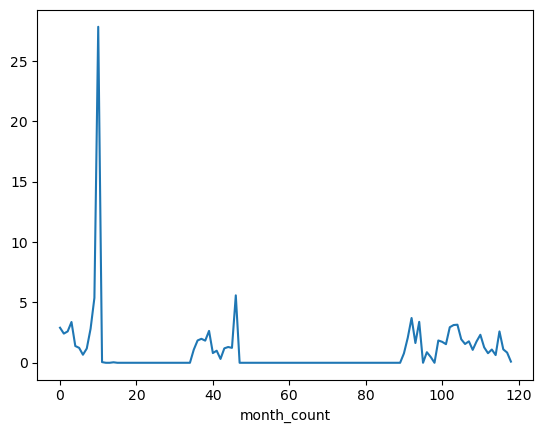

In [9]:
agg_month_store_df[15].plot()

In [97]:
len(week_count)

125807

In [98]:
original_df['week_count'] = week_count
original_df

ValueError: Length of values (125807) does not match length of index (161529)

In [10]:
df_all_sales = agg_month_item_df.sum(axis=1)
df_all_sales

month_count
0        27.107808
1        33.841028
2        28.007791
3        40.296372
4        26.147218
          ...     
114    1470.415086
115    1080.737920
116    1202.469879
117     957.355944
118     323.390091
Length: 119, dtype: float64

<AxesSubplot: xlabel='month_count'>

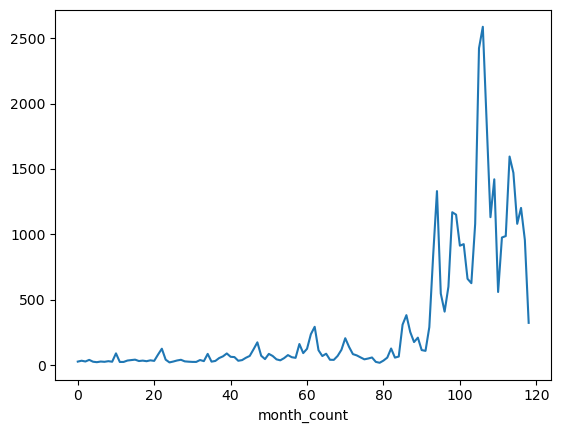

In [11]:
df_all_sales.plot()

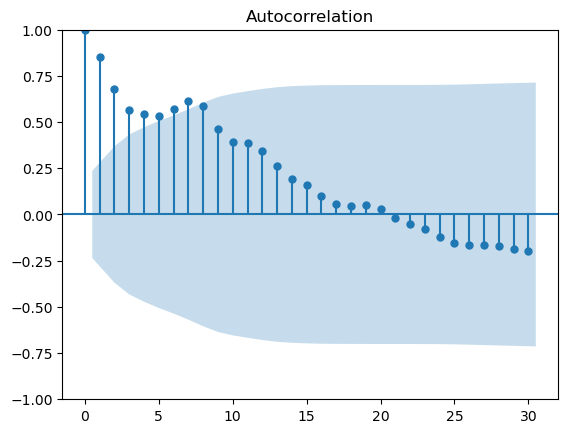

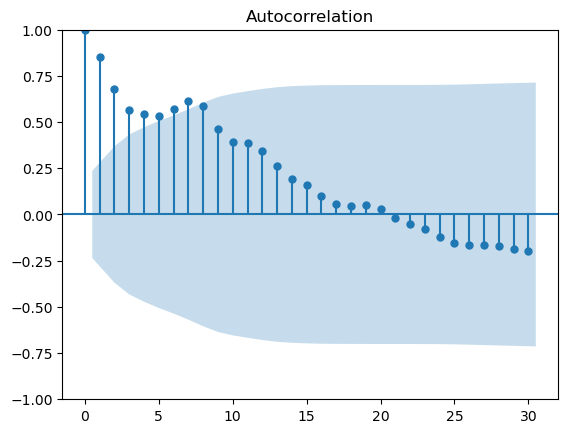

In [12]:
plot_acf(df_all_sales[50:], lags=30)

In [13]:
sm.tsa.stattools.acf(df_all_sales[60:],nlags=12)[12]

0.2982060237081402

#### lets find the autocorellation of all store and sku in n lag = 12 months.

In [14]:
best_corr_store = []
for store in agg_month_store_df:
    best_corr_store.append(sm.tsa.stattools.acf(agg_month_store_df[store][60:],nlags=12)[12])
best_corr_store_df = pd.DataFrame(best_corr_store, index=agg_month_store_df.columns, columns=["Autocorellation nlag = 12"])    
best_corr_store_df.fillna(0, inplace=True)

In [15]:
best_corr_item = []
for sku in agg_month_item_df:
    best_corr_item.append(sm.tsa.stattools.acf(agg_month_item_df[sku][60:],nlags=12)[12])
best_corr_item_df = pd.DataFrame(best_corr_item, index=agg_month_item_df.columns, columns=["Autocorellation nlag = 12"])    
best_corr_item_df.fillna(0, inplace=True)

In [16]:
best_top_store = best_corr_store_df.sort_values("Autocorellation nlag = 12").iloc[-1]
best_top_item = best_corr_item_df.sort_values("Autocorellation nlag = 12").iloc[-1]

In [17]:
best_top_item

Autocorellation nlag = 12    0.71979
Name: 601900, dtype: float64

In [18]:
best_top_store

Autocorellation nlag = 12    0.714093
Name: 160, dtype: float64

In [197]:
sm.tsa.stattools.acf(agg_week_store_df[1043][60:],nlags=12)[12]


0.6500623798071473

In [198]:
agg_week_store_df[1043][60:]

week_count
61     0.481704
62     1.685966
63     1.445113
64     2.167670
65     4.817045
         ...   
520    0.000000
521    0.000000
522    0.000000
523    0.000000
524    0.000000
Name: 1043, Length: 464, dtype: float64

Text(0.5, 1.0, 'Best store: 160 sales over months')

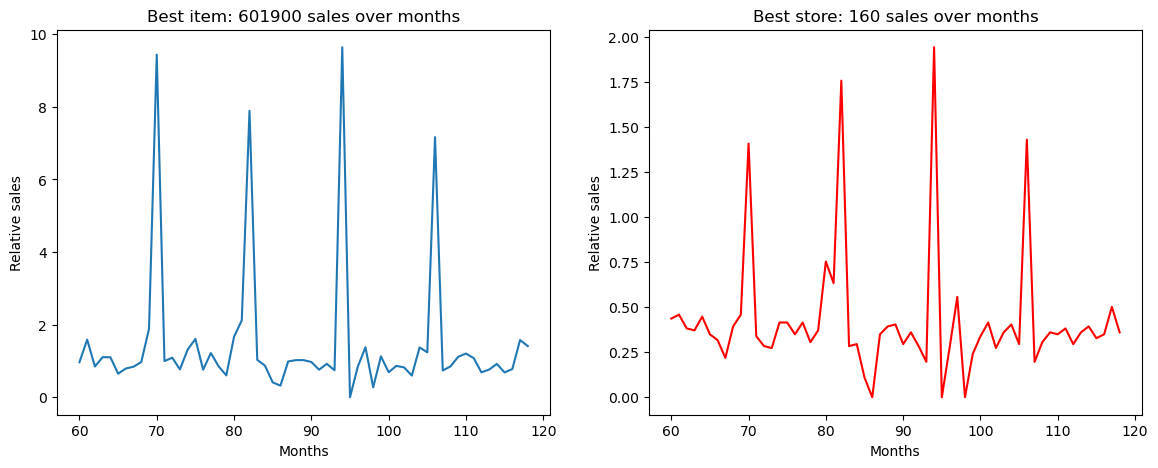

In [19]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_month_item_df[60:][best_top_item.name])
plt.xlabel("Months")
plt.ylabel("Relative sales")
plt.title("Best item: " + str(best_top_item.name) + " sales over months")
plt.subplot(122)
plt.plot(agg_month_store_df[60:][best_top_store.name], 'r')
plt.xlabel("Months")
plt.ylabel("Relative sales")
plt.title("Best store: " + str(best_top_store.name) + " sales over months")

#### we see nice pattern that repeats itself over 12 months in both of plots.

#### We will try to estimate their future sales

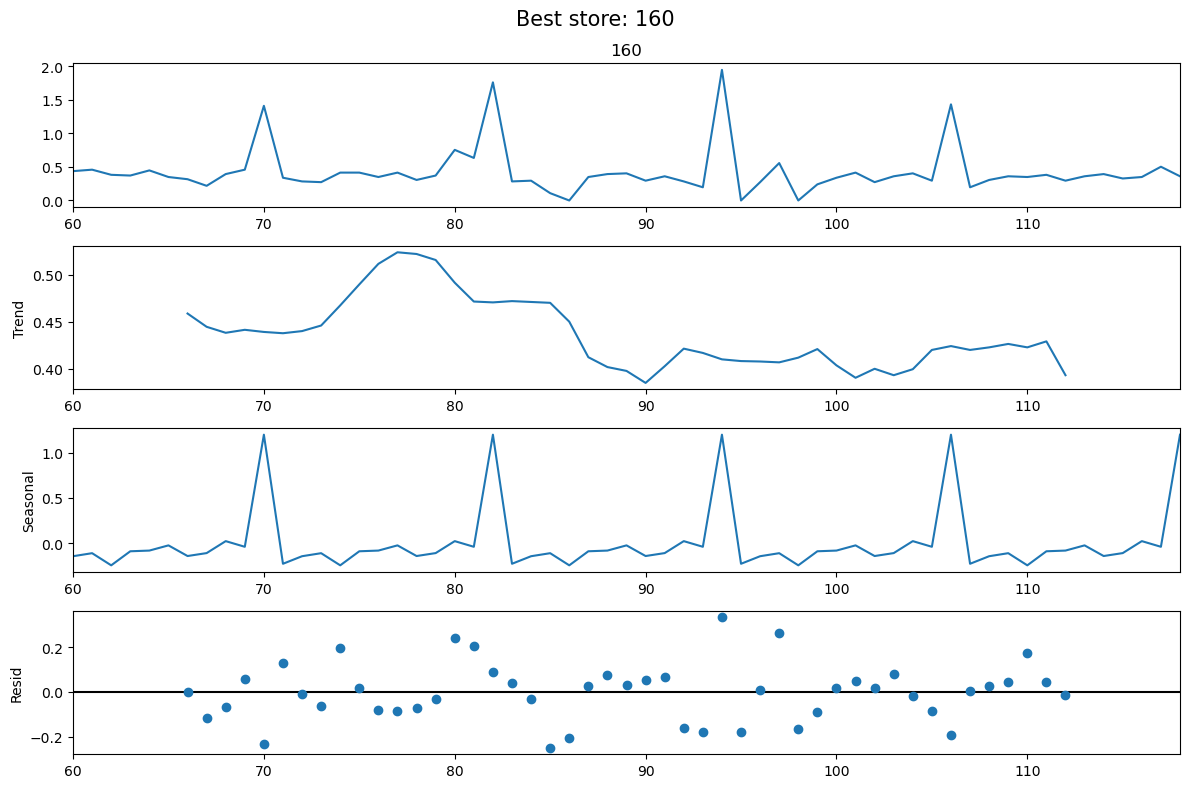

In [20]:
result = seasonal_decompose(agg_month_store_df[60:][best_top_store.name], model='additive', period=12)
fig = result.plot()  
fig.set_size_inches(12, 8)
fig.suptitle("Best store: " + str(best_top_store.name), fontsize= 15)
fig.tight_layout()
fig.show()

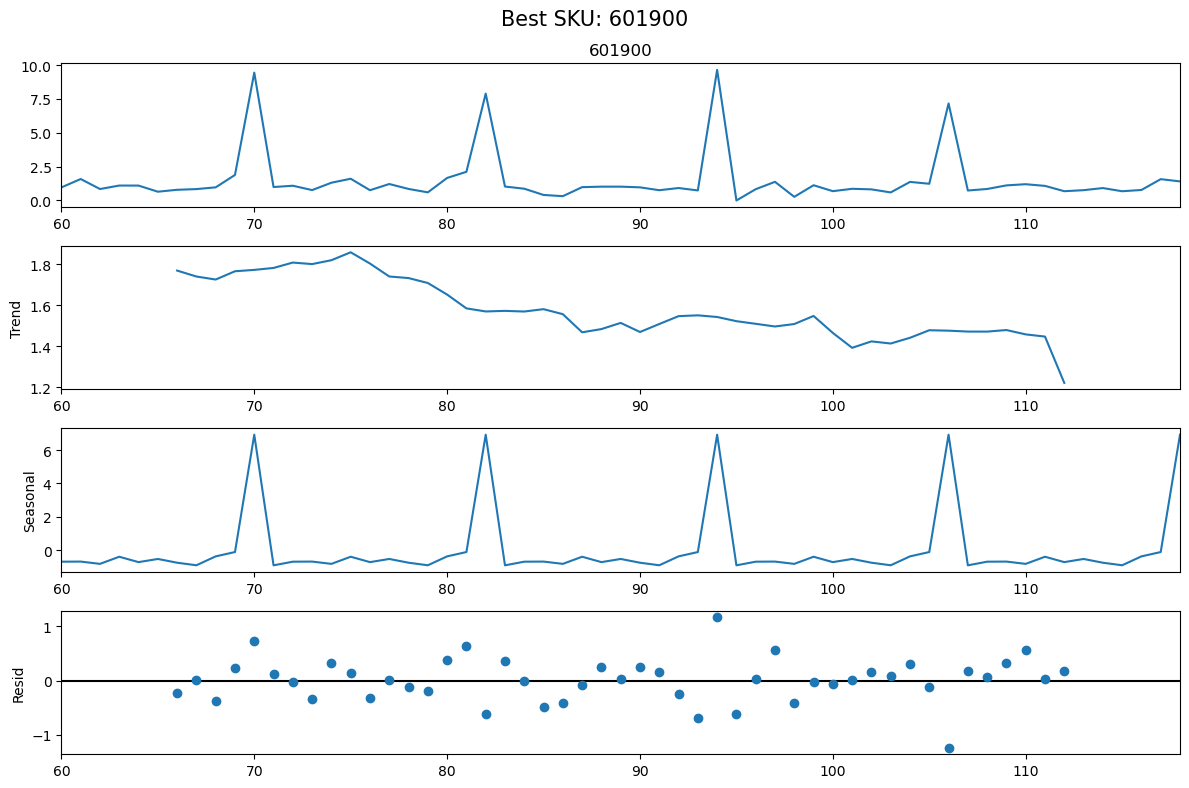

In [21]:
result = seasonal_decompose(agg_month_item_df[60:][best_top_item.name], model='additive', period=12)
fig = result.plot()  
fig.set_size_inches(12, 8)
fig.suptitle("Best SKU: " + str(best_top_item.name), fontsize= 15)
fig.tight_layout()
fig.show()

#### We see that the seasonal graph is quite similar to the real graph of sales but there is a downward trend over time.

In [22]:
df_stationarityTest = adfuller(agg_month_item_df[60:][best_top_item.name], autolag='AIC')
print("Top SKU")
print("P-value: ", df_stationarityTest[1])
df_stationarityTest = adfuller(agg_month_store_df[60:][best_top_store.name], autolag='AIC')
print("Top Store")
print("P-value: ", df_stationarityTest[1])

Top SKU
P-value:  0.9217008462412064
Top Store
P-value:  0.6592167214647495


#### 1-th differences

In [23]:
first_diff_item = agg_month_item_df[60:][best_top_item.name].diff().dropna(inplace = False)
df_stationarityTest = adfuller(first_diff_item, autolag='AIC')
print("Top SKU")
print("P-value: ", df_stationarityTest[1])
first_diff_store = agg_month_store_df[60:][best_top_store.name].diff().dropna(inplace = False)
df_stationarityTest = adfuller(first_diff_store, autolag='AIC')
print("Top Store")
print("P-value: ", df_stationarityTest[1])

Top SKU
P-value:  9.26264597337539e-07
Top Store
P-value:  3.266333778064626e-15


In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

In [24]:
store_train_data = agg_month_store_df[best_top_store.name][60:100].values
store_test_data = agg_month_store_df[best_top_store.name][100:].values
item_train_data = agg_month_item_df[best_top_item.name][60:100].values
item_test_data = agg_month_item_df[best_top_item.name][100:].values

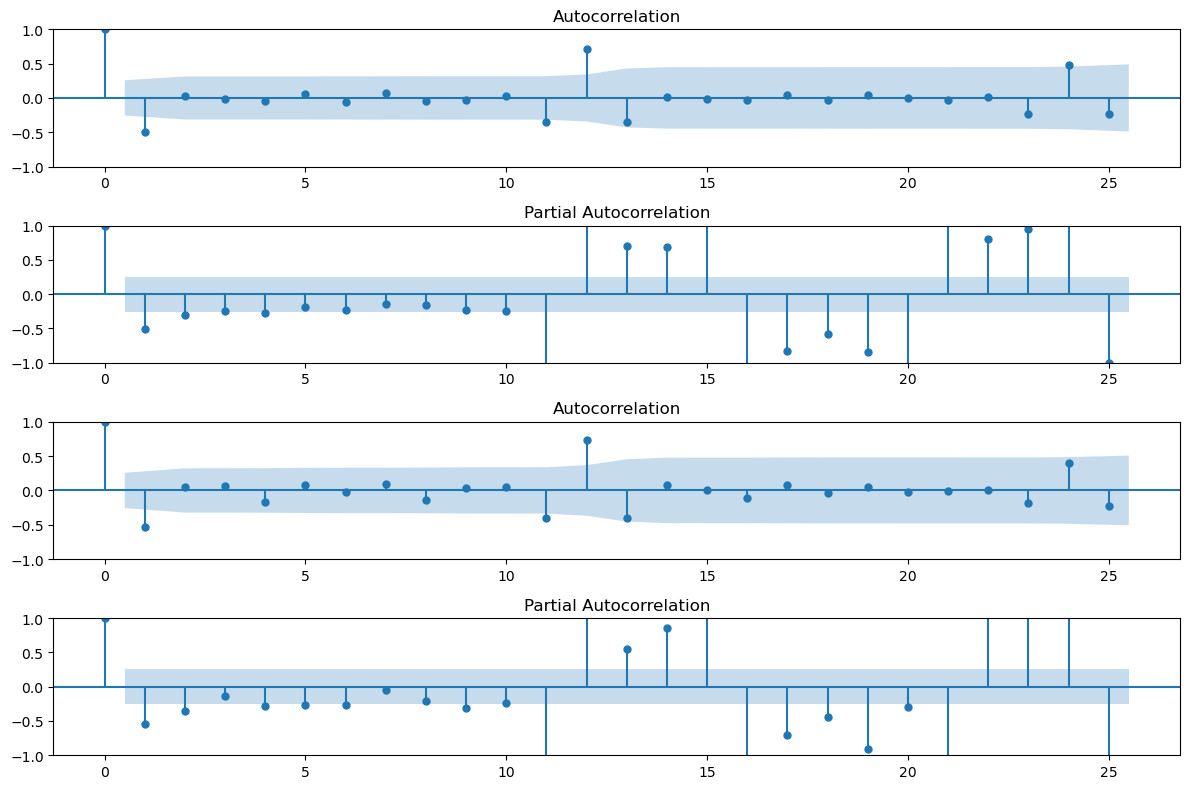

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(first_diff_item, lags=25, ax=ax1) # 
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_pacf(first_diff_item, lags=25, ax=ax2)
ax3 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(first_diff_store, lags=25, ax=ax3) # 
ax4 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(first_diff_store, lags=25, ax=ax4)
fig.tight_layout()

In [30]:
store_train_data

array([ 40,  42,  35,  34,  41,  32,  29,  20,  36,  42, 129,  31,  26,
        25,  38,  38,  32,  38,  28,  34,  69,  58, 161,  26,  27,  10,
         0,  32,  36,  37,  27,  33,  26,  18, 178,   0,  25,  51,   0,
        22], dtype=int64)

In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## AR(p) Model

Autoregressive model represents a regression or prediction of current value that is generated based on the past values from that same time series. Since the current value is based on the nearby previous values, the value doesn’t change instantaneously. For example, body temperature doesn’t go up and down rapidly. It changes steadily and the measurements are close to each other.

In [27]:
AR_model_store = AutoReg(store_train_data, lags=12).fit()
predictions_store = AR_model_store.predict(start=len(store_train_data), end=len(store_train_data)+len(store_test_data)-1)
AR_model_item = AutoReg(item_train_data, lags=12).fit()
predictions_item = AR_model_item.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)

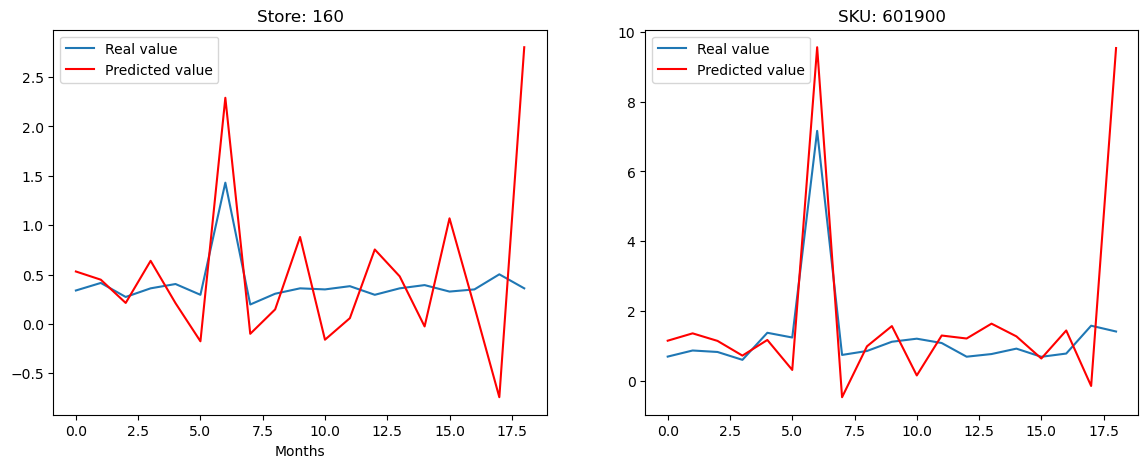

In [28]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(store_test_data, label="Real value")
plt.plot(predictions_store, color='red', label="Predicted value")
plt.title("Store: " + str(best_top_store.name))
plt.xlabel('Months')
plt.legend()

plt.subplot(122)
plt.plot(item_test_data, label="Real value")
plt.plot(predictions_item, color='red', label="Predicted value")
plt.title("SKU: " + str(best_top_item.name))
plt.legend()
plt.show()

In [29]:
MAE = mean_absolute_error(store_test_data, predictions_store)
RMSE = np.sqrt(mean_squared_error(store_test_data, predictions_store))
MAPE = mean_absolute_percentage_error(store_test_data, predictions_store)
print('Store Test MAE: %.3f' % MAE)
print('Store Test RMSE: %.3f' % RMSE)
print('Store Test MAPE: %.3f' % MAPE)
MAE = mean_absolute_error(item_test_data, predictions_item)
RMSE = np.sqrt(mean_squared_error(item_test_data, predictions_item))
MAPE = mean_absolute_percentage_error(item_test_data, predictions_item)
print('SKU Test MAE: %.3f' % MAE)
print('SKU Test RMSE: %.3f' % RMSE)
print('SKU Test MAPE: %.3f' % MAPE)

Store Test MAE: 0.500
Store Test RMSE: 0.739
Store Test MAPE: 132.005
SKU Test MAE: 1.069
SKU Test RMSE: 2.062
SKU Test MAPE: 86.456


## MA(q) model

Moving average model (MA) model generates the current values based on the ERRORS from the past forecasts instead of using the past values like AR. Past errors are analyzed to produce the current value. Perfecting a baking recipe will be like a moving average model. You will do adjustments for needed sugars or butter for today’s baking depending on the previous days’ amount to perfect the recipe.

In [30]:
MA_model_store = ARIMA(store_train_data, order=(0, 0, 4)).fit()
predictions_store = MA_model_store.predict(start=len(store_train_data), end=len(store_train_data)+len(store_test_data)-1)
MA_model_item = ARIMA(store_train_data, order=(0, 0, 4)).fit()
predictions_item = MA_model_item.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)

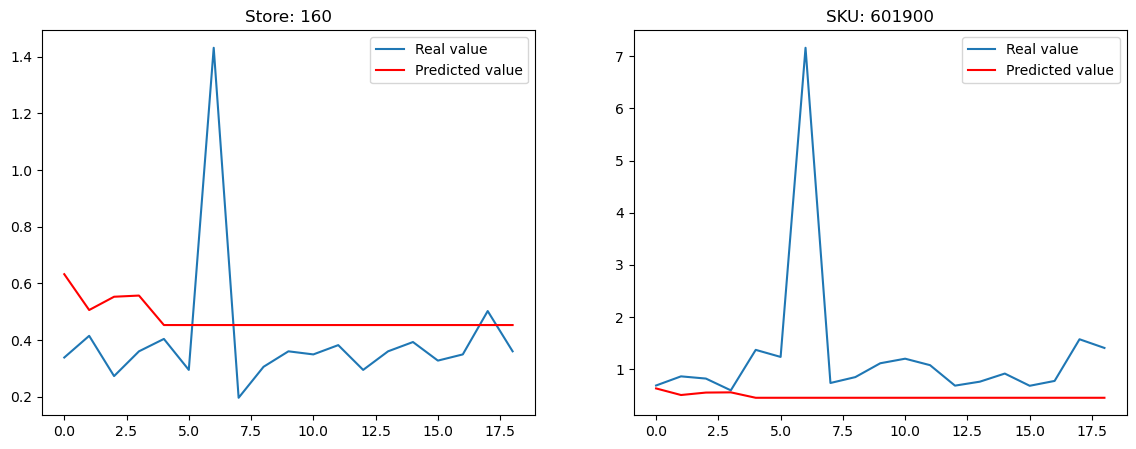

In [31]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(store_test_data, label="Real value")
plt.plot(predictions_store, color='red', label="Predicted value")
plt.title("Store: " + str(best_top_store.name))
plt.legend()

plt.subplot(122)
plt.plot(item_test_data, label="Real value")
plt.plot(predictions_item, color='red', label="Predicted value")
plt.title("SKU: " + str(best_top_item.name))
plt.legend()
plt.show()

In [32]:
MAE = mean_absolute_error(store_test_data, predictions_store)
RMSE = np.sqrt(mean_squared_error(store_test_data, predictions_store))
MAPE = mean_absolute_percentage_error(store_test_data, predictions_store)
print('Store Test MAE: %.3f' % MAE)
print('Store Test RMSE: %.3f' % RMSE)
print('Store Test MAPE: %.3f' % MAPE)
MAE = mean_absolute_error(item_test_data, predictions_item)
RMSE = np.sqrt(mean_squared_error(item_test_data, predictions_item))
MAPE = mean_absolute_percentage_error(item_test_data, predictions_item)
print('SKU Test MAE: %.3f' % MAE)
print('SKU Test RMSE: %.3f' % RMSE)
print('SKU Test MAPE: %.3f' % MAPE)

Store Test MAE: 0.179
Store Test RMSE: 0.270
Store Test MAPE: 44.752
SKU Test MAE: 0.815
SKU Test RMSE: 1.639
SKU Test MAPE: 48.263


## ARMA model(AR + MA)

ARMA is the combination of the AR and MA models. ARMA models cover both aspects of AR and MA. The ARMA model predicts the future values based on both the previous values and errors. Thus ARMA has better performance than AR and MA models alone.

In [33]:
ARMA_model_store = ARIMA(store_train_data, order = (12,0,4)).fit()
predictions_store = ARMA_model_store.predict(start=len(store_train_data), end=len(store_train_data)+len(store_test_data)-1)

In [34]:
ARMA_model_item = ARIMA(item_train_data, order = (12,0,4)).fit()
predictions_item = ARMA_model_item.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)

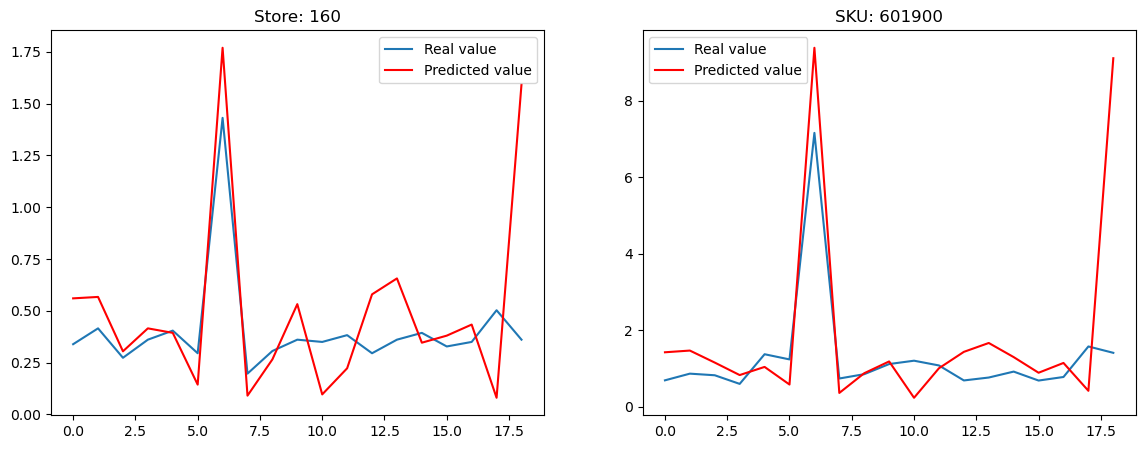

In [35]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(store_test_data, label="Real value")
plt.plot(predictions_store, color='red', label="Predicted value")
plt.title("Store: " + str(best_top_store.name))
plt.legend()
plt.subplot(122)
plt.plot(item_test_data, label="Real value")
plt.plot(predictions_item, color='red', label="Predicted value")
plt.title("SKU: " + str(best_top_item.name))
plt.legend()
plt.show()

In [36]:
MAE = mean_absolute_error(store_test_data, predictions_store)
RMSE = np.sqrt(mean_squared_error(store_test_data, predictions_store))
MAPE = mean_absolute_percentage_error(store_test_data, predictions_store)
print('Store Test MAE: %.3f' % MAE)
print('Store Test RMSE: %.3f' % RMSE)
print('Store Test MAPE: %.3f' % MAPE)
MAE = mean_absolute_error(item_test_data, predictions_item)
RMSE = np.sqrt(mean_squared_error(item_test_data, predictions_item))
MAPE = mean_absolute_percentage_error(item_test_data, predictions_item)
print('SKU Test MAE: %.3f' % MAE)
print('SKU Test RMSE: %.3f' % RMSE)
print('SKU Test MAPE: %.3f' % MAPE)

Store Test MAE: 0.216
Store Test RMSE: 0.342
Store Test MAPE: 57.442
SKU Test MAE: 0.953
SKU Test RMSE: 1.921
SKU Test MAPE: 77.857


## ARIMA model

The difference between ARMA and ARIMA is the integration part. The integrated I stands for the number of times differencing is needed to make the times series stationary. ARIMA models are widely used for real life time series analysis since most times series data are non stationary and need differencing.

In [37]:
ARIMA_model_store = ARIMA(store_train_data, order = (12,1,4)).fit()
predictions_store = ARIMA_model_store.predict(start=len(store_train_data), end=len(store_train_data)+len(store_test_data)-1)

In [38]:
ARIMA_model_item = ARIMA(item_train_data, order = (12,1,4)).fit()
predictions_item = ARIMA_model_item.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)

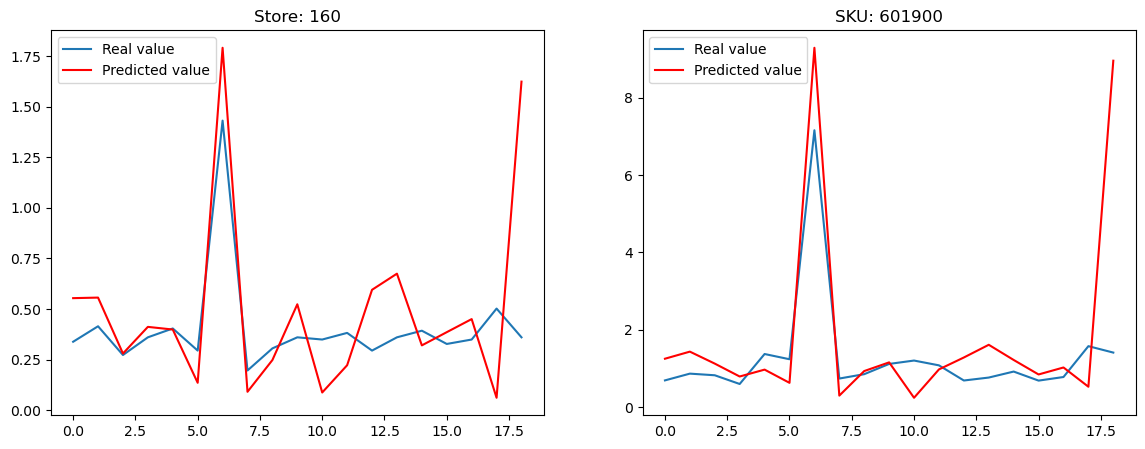

In [39]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(store_test_data, label="Real value")
plt.plot(predictions_store, color='red', label="Predicted value")
plt.title("Store: " + str(best_top_store.name))
plt.legend()
plt.subplot(122)
plt.plot(item_test_data, label="Real value")
plt.plot(predictions_item, color='red', label="Predicted value")
plt.title("SKU: " + str(best_top_item.name))
plt.legend()
plt.show()

In [40]:
MAE = mean_absolute_error(store_test_data, predictions_store)
RMSE = np.sqrt(mean_squared_error(store_test_data, predictions_store))
MAPE = mean_absolute_percentage_error(store_test_data, predictions_store)
print('Store Test MAE: %.3f' % MAE)
print('Store Test RMSE: %.3f' % RMSE)
print('Store Test MAPE: %.3f' % MAPE)
MAE = mean_absolute_error(item_test_data, predictions_item)
RMSE = np.sqrt(mean_squared_error(item_test_data, predictions_item))
MAPE = mean_absolute_percentage_error(item_test_data, predictions_item)
print('SKU Test MAE: %.3f' % MAE)
print('SKU Test RMSE: %.3f' % RMSE)
print('SKU Test MAPE: %.3f' % MAPE)

Store Test MAE: 0.223
Store Test RMSE: 0.352
Store Test MAPE: 59.034
SKU Test MAE: 0.903
SKU Test RMSE: 1.870
SKU Test MAPE: 72.499


## SARIMA

In [64]:
import itertools


NameError: name 'y' is not defined

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

In [41]:
def SARIMA_tunning(train_data, p = range(2,3), d = range(0,1), q = range(0,5),  s = 12):

    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    result_df_sarima = pd.DataFrame(columns=["param", "param_seasonal", "results.aic"])
    index = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                result_df_sarima = result_df_sarima.append({'param': param, 'param_seasonal': param_seasonal, 'results.aic': results.aic}, ignore_index=True)


            except:
                continue
    best_index_results = result_df_sarima["results.aic"].sort_values().index[0]
    print("Loest AIC result : " + str(result_df_sarima['results.aic'][best_index_results]) + " with params: " \
          + str(result_df_sarima['param'][best_index_results]) + "X" + str(result_df_sarima['param_seasonal'][best_index_results]))
    return result_df_sarima, best_index_results

In [42]:
store_results, best_index_store = SARIMA_tunning(store_train_data)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (2, 0, 1) x (2, 0, 1, 12)
SARIMAX: (2, 0, 1) x (2, 0, 2, 12)
SARIMAX: (2, 0, 2) x (2, 0, 3, 12)
SARIMAX: (2, 0, 2) x (2, 0, 4, 12)
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:7.22412353727727
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:8.863026980193352
ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:10.326777703971896
ARIMA(2, 0, 0)x(2, 0, 3, 12)12 - AIC:-40.936748445540914
ARIMA(2, 0, 0)x(2, 0, 4, 12)12 - AIC:18.0
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:3.5940323572421686
ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:2.473210009281839
ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:2.828943980769111
ARIMA(2, 0, 1)x(2, 0, 3, 12)12 - AIC:-23.396953853177536
ARIMA(2, 0, 1)x(2, 0, 4, 12)12 - AIC:20.0
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:9.726791498067701
ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:11.025052985780931
ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:12.378801480643025
ARIMA(2, 0, 2)x(2, 0, 3, 12)12 - AIC:-2.2119531412423115
ARIMA(2, 0, 2)x(2, 0, 4, 12)12 - AIC:22.0
ARIMA(2,

In [61]:
from itertools import product
from tqdm import tqdm_notebook

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [62]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4,store_train_data)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [43]:
item_results, best_index_item = SARIMA_tunning(item_train_data)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (2, 0, 1) x (2, 0, 1, 12)
SARIMAX: (2, 0, 1) x (2, 0, 2, 12)
SARIMAX: (2, 0, 2) x (2, 0, 3, 12)
SARIMAX: (2, 0, 2) x (2, 0, 4, 12)
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:32.846537549459484
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:32.53614559717091
ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:33.34225441894701
ARIMA(2, 0, 0)x(2, 0, 3, 12)12 - AIC:-43.597037665323356
ARIMA(2, 0, 0)x(2, 0, 4, 12)12 - AIC:18.0
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:28.59258950564286
ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:27.87731537777035
ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:28.18014863609394
ARIMA(2, 0, 1)x(2, 0, 3, 12)12 - AIC:-26.067930557452804
ARIMA(2, 0, 1)x(2, 0, 4, 12)12 - AIC:20.0
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:24.90080604553568
ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:25.34070708074851
ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:27.321290901598267
ARIMA(2, 0, 2)x(2, 0, 3, 12)12 - AIC:-2.1922205166320836
ARIMA(2, 0, 2)x(2, 0, 4, 12)12 - AIC:22.0
ARIMA(2, 

In [66]:
item_results[0]

,param,param_seasonal,results.aic
0,"(2, 0, 0)","(2, 0, 0, 12)",32.846538
1,"(2, 0, 0)","(2, 0, 1, 12)",32.536146
2,"(2, 0, 0)","(2, 0, 2, 12)",33.342254
3,"(2, 0, 0)","(2, 0, 3, 12)",-43.597038
4,"(2, 0, 0)","(2, 0, 4, 12)",18.000000
5,"(2, 0, 1)","(2, 0, 0, 12)",28.592590
6,"(2, 0, 1)","(2, 0, 1, 12)",27.877315
7,"(2, 0, 1)","(2, 0, 2, 12)",28.180149
8,"(2, 0, 1)","(2, 0, 3, 12)",-26.067931
9,"(2, 0, 1)","(2, 0, 4, 12)",20.000000


In [44]:
store_results

,param,param_seasonal,results.aic
0,"(2, 0, 0)","(2, 0, 0, 12)",7.224124
1,"(2, 0, 0)","(2, 0, 1, 12)",8.863027
2,"(2, 0, 0)","(2, 0, 2, 12)",10.326778
3,"(2, 0, 0)","(2, 0, 3, 12)",-40.936748
4,"(2, 0, 0)","(2, 0, 4, 12)",18.000000
5,"(2, 0, 1)","(2, 0, 0, 12)",3.594032
6,"(2, 0, 1)","(2, 0, 1, 12)",2.473210
7,"(2, 0, 1)","(2, 0, 2, 12)",2.828944
8,"(2, 0, 1)","(2, 0, 3, 12)",-23.396954
9,"(2, 0, 1)","(2, 0, 4, 12)",20.000000


In [45]:
SARIMA_best_model_store = sm.tsa.statespace.SARIMAX(store_train_data,
                                            order=store_results['param'][best_index_store],
                                            seasonal_order=store_results['param_seasonal'][best_index_store],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit()

predictions_item = SARIMA_best_model_store.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)

SARIMA_best_model_item = sm.tsa.statespace.SARIMAX(item_train_data,
                                            order=item_results['param'][best_index_item],
                                            seasonal_order=item_results['param_seasonal'][best_index_item],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit()

predictions_store = SARIMA_best_model_item.predict(start=len(item_train_data), end=len(item_train_data)+len(item_test_data)-1)


In [60]:
store_results[0]

,param,param_seasonal,results.aic
0,"(2, 0, 0)","(2, 0, 0, 12)",7.224124
1,"(2, 0, 0)","(2, 0, 1, 12)",8.863027
2,"(2, 0, 0)","(2, 0, 2, 12)",10.326778
3,"(2, 0, 0)","(2, 0, 3, 12)",-40.936748
4,"(2, 0, 0)","(2, 0, 4, 12)",18.000000
5,"(2, 0, 1)","(2, 0, 0, 12)",3.594032
6,"(2, 0, 1)","(2, 0, 1, 12)",2.473210
7,"(2, 0, 1)","(2, 0, 2, 12)",2.828944
8,"(2, 0, 1)","(2, 0, 3, 12)",-23.396954
9,"(2, 0, 1)","(2, 0, 4, 12)",20.000000


In [75]:
predictions_item

array([ 0.70110401,  0.82098023,  0.32232375,  0.45378682,  0.56416536,
        0.32805281,  2.8996333 ,  0.00547234,  0.50385445,  0.83627151,
       -0.04989781,  0.41306657,  1.11532682,  1.23935113,  0.49528358,
        0.73652551,  0.87202962,  0.48887572,  4.52205191])

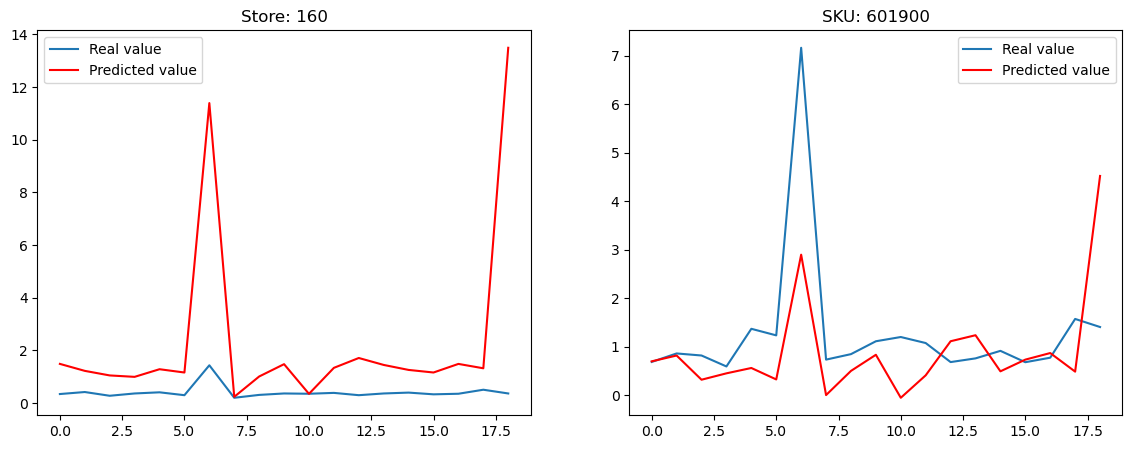

In [46]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(store_test_data, label="Real value")
plt.plot(predictions_store, color='red', label="Predicted value")
plt.title("Store: " + str(best_top_store.name))
plt.legend()
plt.subplot(122)
plt.plot(item_test_data, label="Real value")
plt.plot(predictions_item, color='red', label="Predicted value")
plt.title("SKU: " + str(best_top_item.name))
plt.legend()
plt.show()

In [47]:
MAPE

72.49897429822862

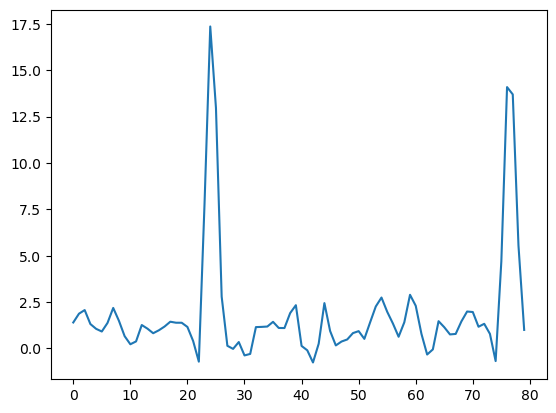

In [39]:
plt.plot(predictions_item)

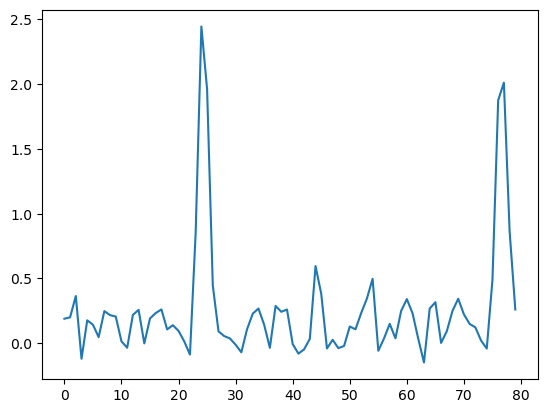

In [37]:
plt.plot(predictions_store)